In [1]:
import glob
import numpy as np
from pathlib import Path
import shutil

def create_pcb_train_val_test(data_dir='PCBData',
                              train_dir='PCBData/train',
                              val_dir='PCBData/val',
                              test_dir='PCBData/test'
                             ):
    #all_files = glob.glob(data_dir+'/@(NG|OK)/*.jpg', flags=pathlib.GLOBSTAR | pathlib.EXTGLOB)
    ng_files = sorted(glob.glob(data_dir+"/NG/*.jpg"))
    n_ng = len(ng_files)
    ok_files = sorted(glob.glob(data_dir+"/OK/*.jpg"))
    n_ok = len(ok_files)
    #creating a new directory called pythondirectory
    Path(train_dir+'/OK').mkdir(parents=True, exist_ok=True)
    Path(train_dir+'/NG').mkdir(parents=True, exist_ok=True)
    Path(val_dir+'/OK').mkdir(parents=True, exist_ok=True)
    Path(val_dir+'/NG').mkdir(parents=True, exist_ok=True)
    np.random.seed(42)
    perm = np.random.permutation(n_ng)
    n_val = int(n_ng*0.1)//4*4
    n_train = n_ng - n_val
    src_files = ng_files
    
    train_idx = perm[:n_train]
    val_idx = perm[n_train:]
    for i in train_idx:
        src = src_files[i]
        dst = train_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
    for i in val_idx:
        src = src_files[i]
        dst = val_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
        
    perm = np.random.permutation(n_ok)
    n_val = int(n_ok*0.1)*4//4
    n_train = n_ok - n_val
    src_files = ok_files
    
    train_idx = perm[:n_train]
    val_idx = perm[n_train:]
    for i in train_idx:
        src = src_files[i]
        dst = train_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
    for i in val_idx:
        src = src_files[i]
        dst = val_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
        
#create_pcb_train_val_test()

In [2]:
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS

In [1]:
import argparse
from pathlib import Path

import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
import torchmetrics
from timm.scheduler import CosineLRScheduler
from torchvision import transforms

from pytorch_accelerated.callbacks import SaveBestModelCallback, ProgressBarCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS
from pytorch_accelerated.run_config import TrainerRunConfig
from pytorch_accelerated.utils import local_process_zero_only

from PIL import Image

from tqdm.auto import tqdm
import time
import pandas as pd

from accelerate import notebook_launcher
import accelerate

from torch.utils.data import Dataset
import numpy as np
import glob

class PCBData(Dataset):
    def __init__(self, root_dir, transform=None, stage='val'):
        self.root_dir = root_dir
        self.transform = transform
        image_files = np.array(sorted(glob.glob('PCB_data/*/*.jpg')))
        image_labels = np.array([ 0 if filename.split('/')[1]=='NG' else 1 for filename in image_files])
        train_ratio = 0.8
        val_ratio = 0.1
        n_all = len(image_labels)
        n_ng = len(image_labels[image_labels==0])
        n_ok = n_all - n_ng
        ng_indices = np.array([i for i in range(n_ng)])
        ok_indices = np.array([i for i in range(n_ng, n_all)])
        np.random.seed(42)
        ng_perm = np.random.permutation(ng_indices)
        n_ng_train = int(n_ng*0.8)
        n_ng_val = int(n_ng*0.1)
        ng_train_indices = ng_perm[:n_ng_train]
        ng_val_indices = ng_perm[n_ng_train:n_ng_train+n_ng_val]
        ng_test_indices = ng_perm[n_ng_train+n_ng_val:]
        ok_perm = np.random.permutation(ok_indices)
        n_ok_train = int(n_ok*0.8)
        n_ok_val = int(n_ok*0.1)
        ok_train_indices = ok_perm[:n_ok_train]
        ok_val_indices = ok_perm[n_ok_train:n_ok_train+n_ok_val]
        ok_test_indices = ok_perm[n_ok_train+n_ok_val:]
        train_indices = np.concatenate((ng_train_indices, ok_train_indices))
        val_indices = np.concatenate((ng_val_indices, ok_val_indices))
        test_indices = np.concatenate((ng_test_indices, ok_test_indices))
        if stage == 'train':
            indices = train_indices
        elif stage == 'val':
            indices = val_indices
        else:
            indices = test_indices
        self.files = list(zip(image_files[indices], image_labels[indices]))
        '''
        self.classes = ['NG', 'OK']
        self.files = []
        for index, label in enumerate(self.classes):
            path = os.path.join(self.root_dir, label)
            files = os.listdir(path)
            for file in files:
                self.files.append((os.path.join(path, file), index))
        '''

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def img_file(self, idx):
        return self.files[idx]

class TQDM_progressbar(ProgressBarCallback):
    """
    A callback which visualises the state of each training and evaluation epoch using a progress bar
    """

    def __init__(self):
        self.pbar = None

    def on_train_epoch_start(self, trainer, **kwargs):
        self.pbar = tqdm(
            total=len(trainer._train_dataloader),
            disable=not trainer._accelerator.is_local_main_process,
        )

    def on_train_step_end(self, trainer, **kwargs):
        self.pbar.update(1)

    def on_train_epoch_end(self, trainer, **kwargs):
        self.pbar.close()
        time.sleep(0.01)

    def on_eval_epoch_start(self, trainer, **kwargs):
        self.pbar = tqdm(
            total=len(trainer._eval_dataloader),
            disable=not trainer._accelerator.is_local_main_process,
        )

    def on_eval_step_end(self, trainer, **kwargs):
        self.pbar.update(1)

    def on_eval_epoch_end(self, trainer, **kwargs):
        self.pbar.close()
        time.sleep(0.01)

class ImageDataset_new(timm.data.dataset.ImageDataset):
    def __init__(
            self,
            root,
            reader=None,
            split='train',
            class_map=None,
            load_bytes=False,
            input_img_mode='RGB',
            transform=None,
            target_transform=None,
    ):
        super().__init__(root, reader, split, class_map, load_bytes, input_img_mode, transform, target_transform)
        
    def __getitem__(self, index):
        img, target = self.reader[index]

        '''
        try:
            img = img.read() if self.load_bytes else Image.open(img)
        except Exception as e:
            _logger.warning(f'Skipped sample (index {index}, file {self.reader.filename(index)}). {str(e)}')
            self._consecutive_errors += 1
            if self._consecutive_errors < _ERROR_RETRY:
                return self.__getitem__((index + 1) % len(self.reader))
            else:
                raise e
        '''
        self._consecutive_errors = 0

        with Image.open(img) as im:
            if self.input_img_mode and not self.load_bytes:
                img = im.convert(self.input_img_mode)
            
        if self.transform is not None:
            img = self.transform(img)

        if target is None:
            target = -1
        elif self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

import random
from typing import Sequence

class RotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles
        self.count = 0

    def __call__(self, x):
        angle = random.choice(self.angles)
        if angle == 0:
            return x
        else:
            return transforms.functional.rotate(x, angle)

#def create_datasets(image_size, data_mean, data_std, train_path, val_path):
def create_datasets(image_size, data_mean, data_std, path):
    '''
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        hflip=0.5,
        vflip=0.3,
        #auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )
    '''
    train_transforms = transforms.Compose(
        [
            transforms.RandomCrop((224,224)),
            transforms.RandomVerticalFlip(),  # 상하반전 
            RotateTransform([0,90,180,270]),
            #transforms.RandomHorizontalFlip(),  # 좌우반전 
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )
    
    eval_transforms = transforms.Compose(
        [
            transforms.CenterCrop((224,224)),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )

    #train_dataset = timm.data.dataset.ImageDataset_new(
    #train_dataset = ImageDataset_new(
        #train_path, transform=train_transforms, load_bytes=False
    #)
    #eval_dataset = timm.data.dataset.ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    #eval_dataset = ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    '''
    from torchvision import datasets
    train_dataset = datasets.ImageFolder(train_path, train_transforms)
    eval_dataset = datasets.ImageFolder(val_path, eval_transforms)

    return train_dataset, eval_dataset
    '''
    train_dataset = PCBData('./PCB_data', transform=train_transforms, stage='train')
    val_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='val')
    test_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='test')

    return train_dataset, val_dataset, test_dataset


class TimmMixupTrainer(Trainer):
    def __init__(self, eval_loss_fn, mixup_args, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        self.num_updates = None
        #self.mixup_fn = timm.data.Mixup(**mixup_args)

        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_model = None

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1,
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9
        )
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch):
        xb, yb = batch
        #mixup_xb, mixup_yb = self.mixup_fn(xb, yb)
        #return super().calculate_train_batch_loss((mixup_xb, mixup_yb))
        return super().calculate_train_batch_loss((xb, yb))

    def train_epoch_end(
        self,
    ):
        self.ema_model.update(self.model)
        self.ema_model.eval()

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

        # learning rate log
        self.run_history.update_metric("lr", self.optimizer.param_groups[0]['lr'])

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)
            val_loss = self.eval_loss_fn(outputs, yb)
            self.accuracy.update(outputs.argmax(-1), yb)

            if self.ema_model is not None:
                ema_model_preds = self.ema_model.module(xb).argmax(-1)
                self.ema_accuracy.update(ema_model_preds, yb)

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric(
            "ema_model_accuracy", self.ema_accuracy.compute().cpu()
        )
        self.accuracy.reset()
        self.ema_accuracy.reset()

data_path='PCB_data'
# Set training arguments, hardcoded here for clarity
image_size = (224, 224)
#lr = 5e-3
lr = 0.00015
smoothing = 0.1
mixup = 0.2
cutmix = 1.0
batch_size = 32
bce_target_thresh = 0.2
num_epochs = 20

data_path = Path(data_path)
train_path = data_path / "train"
val_path = data_path / "val"

num_classes = len(list(data_path.iterdir()))

mixup_args = dict(
    mixup_alpha=mixup,
    cutmix_alpha=cutmix,
    label_smoothing=smoothing,
    num_classes=num_classes,
)

# Create model using timm
model = timm.create_model(
    #"resnet50d", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    #"efficientnet_b4.ra2_in1k", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    #"davit_tiny", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    "davit_small", pretrained=True, num_classes=num_classes, drop_path_rate=0.15
    #"davit_tiny", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    #"davit_tiny", pretrained=True, num_classes=num_classes
    #"efficientvit_b3.r224_in1k", pretrained=True, num_classes=num_classes
    #"vit_base_patch16_clip_224.openai", pretrained=True, num_classes=num_classes
    #"vit_base_patch16_224", pretrained=True, num_classes=num_classes
)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]

class PCB_model(torch.nn.Module):
    def __init__(self, model):
        super().__init__()

        self.backbone = model 
        #self.softmax = torch.nn.Softmax(dim=1)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.softmax(x)
        return x

model = PCB_model(model)

# Create training and validation datasets
train_dataset, eval_dataset, test_dataset = create_datasets(
    path = data_path,
    #train_path=train_path,
    #val_path=val_path,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)

def my_train():
    # Create optimizer
    optimizer = timm.optim.create_optimizer_v2(
        model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
    )

    # As we are using Mixup, we can use BCE during training and CE for evaluation
    #train_loss_fn = timm.loss.BinaryCrossEntropy(
    #    target_threshold=bce_target_thresh, smoothing=smoothing
    #)
    #train_loss_fn = torch.nn.CrossEntropyLoss()
    #validate_loss_fn = torch.nn.CrossEntropyLoss()
    train_loss_fn = torch.nn.NLLLoss()
    validate_loss_fn = torch.nn.NLLLoss()

    default_callbacks = list(DEFAULT_CALLBACKS)
    default_callbacks.pop(3)

    # Create trainer and start training
    trainer = TimmMixupTrainer(
        model=model,
        optimizer=optimizer,
        loss_func=train_loss_fn,
        eval_loss_fn=validate_loss_fn,
        mixup_args=mixup_args,
        num_classes=num_classes,
        callbacks=[
            #*DEFAULT_CALLBACKS,
            *default_callbacks,
            SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
            TQDM_progressbar,
        ],
    )

    trainer.train(
        per_device_batch_size=batch_size,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        num_epochs=num_epochs,
        create_scheduler_fn=trainer.create_scheduler,
    )
    
    @local_process_zero_only
    def save_history():
        #print(trainer.run_history.get_metric_names())
        train_loss_epoch = trainer.run_history.get_metric_values('train_loss_epoch')
        eval_loss_epoch = trainer.run_history.get_metric_values('eval_loss_epoch')
        accuracy = trainer.run_history.get_metric_values('accuracy')
        accuracy = [acc.numpy() for acc in accuracy]
        lr = trainer.run_history.get_metric_values('lr')
        df = pd.DataFrame(data={'train_loss': train_loss_epoch,
                                'val_loss': eval_loss_epoch,
                                'val_acc': accuracy,
                                'lr': lr,
                               })
        df.to_csv('train_history.csv', index=False)
        #print(trainer.scheduler._get_lr())

    save_history()
    
    #trainer.evaluate(
    #    per_device_batch_size=batch_size,
    #    dataset=eval_dataset,
    #)

'''
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Simple example of training script using timm.")
    parser.add_argument("--data_dir", required=True, help="The data folder on disk.")
    #args = parser.parse_args(args=['--data_dir=imagenette2-320'])
    args = parser.parse_args(args=['--data_dir=PCBData'])
    main(args.data_dir)
'''

notebook_launcher(my_train, num_processes=4)
#my_train()

Launching training on 4 GPUs.


/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:708: UserWarning: The per device batch size 32 with the eval dataset size 1275 and the number of processes 4 will cause one process to have a smaller number of samples on the last batch than the rest, which would lead to a `Trainer.gather` to freeze indefinitely. This can be resolved by passing a `padding_value` to the `Trainer.gather`.
  warnings.warn(
/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:708: UserWarning: The per device batch size 32 with the eval dataset size 1275 and the number of processes 4 will cause one process to have a smaller number of samples on the last batch than the rest, which would lead to a `Trainer.gather` to freeze indefinitely. This can be resolved by passing a `padding_value` to the `Trainer.gather`.
  warnings.warn(
/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:708: UserWarning: The per d


Starting training run

Starting epoch 1


  0%|          | 0/80 [00:00<?, ?it/s]

/home/kotech/venv-lightning/lib/python3.8/site-packages/torch/autograd/__init__.py:266: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [768, 1, 3, 3], strides() = [9, 1, 3, 1]
bucket_view.sizes() = [768, 1, 3, 3], strides() = [9, 9, 3, 1] (Triggered internally at ../torch/csrc/distributed/c10d/reducer.cpp:322.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/kotech/venv-lightning/lib/python3.8/site-packages/torch/autograd/__init__.py:266: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [768, 1


train_loss_epoch: 0.27464231848716736


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 0.0001

ema_model_accuracy: 0.792941153049469

eval_loss_epoch: 0.14443646371364594

accuracy: 0.9435294270515442

Starting epoch 2


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.15400803089141846


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 0.00013333333333333334

ema_model_accuracy: 0.7960784435272217

eval_loss_epoch: 0.1315459907054901

accuracy: 0.9490196108818054

Starting epoch 3


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.14176079630851746


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 0.00014187998605203337

ema_model_accuracy: 0.8141176700592041

eval_loss_epoch: 0.11274028569459915

accuracy: 0.9545097947120667

Starting epoch 4


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.12855204939842224


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 0.00013577176608093358

ema_model_accuracy: 0.843137264251709

eval_loss_epoch: 0.10699759423732758

accuracy: 0.955294132232666

Starting epoch 5


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.12104697525501251


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 0.00012817945519839777

ema_model_accuracy: 0.8658823370933533

eval_loss_epoch: 0.11559558659791946

accuracy: 0.9513725638389587

Starting epoch 6


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.11699934303760529


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 0.00011929000129578923

ema_model_accuracy: 0.8972548842430115

eval_loss_epoch: 0.10137864947319031

accuracy: 0.9607843160629272

Starting epoch 7


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.11296886205673218


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 0.00010932229223059623

ema_model_accuracy: 0.9192156791687012

eval_loss_epoch: 0.10263209789991379

accuracy: 0.9623529314994812

Starting epoch 8


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.10787351429462433


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 9.852176608093358e-05

ema_model_accuracy: 0.9396078586578369

eval_loss_epoch: 0.1064501702785492

accuracy: 0.9607843160629272

Starting epoch 9


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.10830553621053696


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 8.71543676454972e-05

ema_model_accuracy: 0.9513725638389587

eval_loss_epoch: 0.10313723236322403

accuracy: 0.9599999785423279

Starting epoch 10


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.10007421672344208


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 7.549999999999999e-05

ema_model_accuracy: 0.9529411792755127

eval_loss_epoch: 0.10607197135686874

accuracy: 0.95686274766922

Starting epoch 11


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.09798840433359146


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 6.384563235450281e-05

ema_model_accuracy: 0.9537255167961121

eval_loss_epoch: 0.11315596103668213

accuracy: 0.95686274766922

Starting epoch 12


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.09495113790035248


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 5.247823391906642e-05

ema_model_accuracy: 0.955294132232666

eval_loss_epoch: 0.10845973342657089

accuracy: 0.9576470851898193

Starting epoch 13


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.09185709804296494


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 4.167770776940376e-05

ema_model_accuracy: 0.9592157006263733

eval_loss_epoch: 0.11073459684848785

accuracy: 0.9560784101486206

Starting epoch 14


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.08575024455785751


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 3.170999870421075e-05

ema_model_accuracy: 0.9599999785423279

eval_loss_epoch: 0.11073792725801468

accuracy: 0.9576470851898193

Starting epoch 15


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.08748804777860641


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 2.2820544801602213e-05

ema_model_accuracy: 0.9615686535835266

eval_loss_epoch: 0.1091858372092247

accuracy: 0.95686274766922

Starting epoch 16


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.08397384732961655


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 1.5228233919066423e-05

ema_model_accuracy: 0.9607843160629272

eval_loss_epoch: 0.11242944002151489

accuracy: 0.95686274766922

Starting epoch 17


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.0809812992811203


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 9.120013947966599e-06

ema_model_accuracy: 0.9607843160629272

eval_loss_epoch: 0.11223433166742325

accuracy: 0.95686274766922

Starting epoch 18


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.08088631927967072


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 4.6462895360110614e-06

ema_model_accuracy: 0.9599999785423279

eval_loss_epoch: 0.11168447136878967

accuracy: 0.9592157006263733

Starting epoch 19


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.08003973960876465


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 1.9172186256622444e-06

ema_model_accuracy: 0.9599999785423279

eval_loss_epoch: 0.11218877136707306

accuracy: 0.9576470851898193

Starting epoch 20


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.07823950797319412


  0%|          | 0/10 [00:00<?, ?it/s]


lr: 1e-06

ema_model_accuracy: 0.9599999785423279

eval_loss_epoch: 0.11213352531194687

accuracy: 0.9576470851898193
Finishing training run
Loading checkpoint with accuracy: 0.9623529314994812 from epoch 7


In [2]:
model

PCB_model(
  (backbone): DaVit(
    (stem): Stem(
      (conv): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm2d((96,), eps=1e-05, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): DaVitStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): Sequential(
            (0): SpatialBlock(
              (cpe1): ConvPosEnc(
                (proj): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
                (act): Identity()
              )
              (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (softmax): Softmax(dim=-1)
              )
              (drop_path1): Identity()
              (cpe2): ConvPosEnc(
                (proj): Conv2d(96, 96, kerne

In [3]:
!cp train_history.csv train_history_davit.csv
!cp best_model.pt best_model_davit.pt

In [4]:
df = pd.read_csv('train_history_davit.csv')
df

train_loss  val_loss   val_acc        lr
0     0.274642  0.144436  0.943529  0.000100
1     0.154008  0.131546  0.949020  0.000133
2     0.141761  0.112740  0.954510  0.000142
3     0.128552  0.106998  0.955294  0.000136
4     0.121047  0.115596  0.951373  0.000128
5     0.116999  0.101379  0.960784  0.000119
6     0.112969  0.102632  0.962353  0.000109
7     0.107874  0.106450  0.960784  0.000099
8     0.108306  0.103137  0.960000  0.000087
9     0.100074  0.106072  0.956863  0.000075
10    0.097988  0.113156  0.956863  0.000064
11    0.094951  0.108460  0.957647  0.000052
12    0.091857  0.110735  0.956078  0.000042
13    0.085750  0.110738  0.957647  0.000032
14    0.087488  0.109186  0.956863  0.000023
15    0.083974  0.112429  0.956863  0.000015
16    0.080981  0.112234  0.956863  0.000009
17    0.080886  0.111684  0.959216  0.000005
18    0.080040  0.112189  0.957647  0.000002
19    0.078240  0.112134  0.957647  0.000001

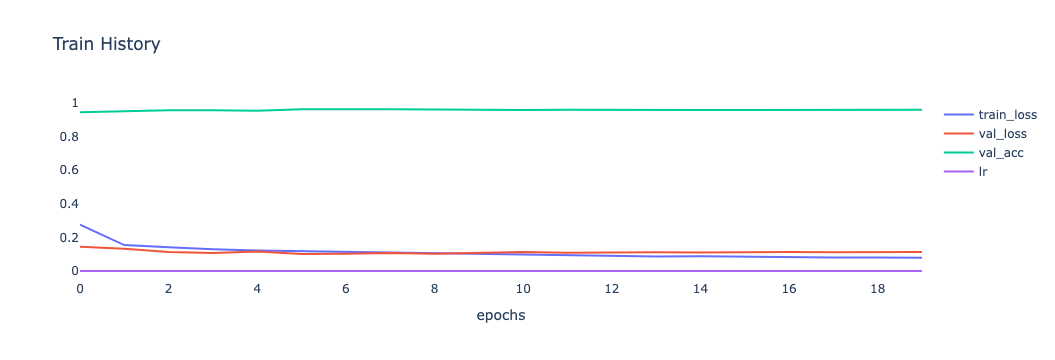

In [5]:
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import plot



data = [go.Scatter(x=df.index,
                   y=df[col],
                   name=col) for col in df.columns]

layout = go.Layout(
    plot_bgcolor="white",
    title='Train History',
    xaxis=dict(title='epochs')
)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [6]:
import timm
import timm.optim
# Create optimizer
optimizer = timm.optim.create_optimizer_v2(
    model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
)

# As we are using Mixup, we can use BCE during training and CE for evaluation
train_loss_fn = timm.loss.BinaryCrossEntropy(
    target_threshold=bce_target_thresh, smoothing=smoothing
)
validate_loss_fn = torch.nn.CrossEntropyLoss()
eval_trainer = TimmMixupTrainer(
    model=model,
    optimizer=optimizer,
    loss_func=train_loss_fn,
    eval_loss_fn=validate_loss_fn,
    mixup_args=mixup_args,
    num_classes=num_classes,
    callbacks=[
        *DEFAULT_CALLBACKS,
        #TQDM_progressbar,
    ],
)
eval_trainer.load_checkpoint('best_model.pt', load_optimizer=False)
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=eval_dataset,
      )


Starting evaluation run


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [00:03<00:00, 15.24it/s]/home/kotech/venv-lightning/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning:

The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.97it/s]


accuracy: 0.9623529314994812

ema_model_accuracy: 0.0

evaluation_loss: 0.10263209789991379
Finishing evaluation run


In [7]:
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=test_dataset,
      )


Starting evaluation run


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.43it/s]


accuracy: 0.9608457088470459

ema_model_accuracy: 0.0

evaluation_loss: 0.10864254087209702
Finishing evaluation run


In [8]:
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=train_dataset,
      )


Starting evaluation run


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:21<00:00, 15.05it/s]


accuracy: 0.9577699303627014

ema_model_accuracy: 0.0

evaluation_loss: 0.1017066165804863
Finishing evaluation run


In [9]:
def create_eval_datasets(image_size, data_mean, data_std, train_path, val_path):
    '''
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        hflip=0.5,
        vflip=0.3,
        #auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )
    '''
    train_transforms = transforms.Compose(
        [
            #transforms.CenterCrop((224,224)),
            #transforms.RandomCrop((224,224)),
            #transforms.RandomHorizontalFlip(),  # 좌우반전 
            #RotateTransform([0,90,180,270]),
            #transforms.RandomVerticalFlip(),  # 상하반전 
            #transforms.RandomVerticalFlip(),  # 상하반전 
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )
    
    eval_transforms = transforms.Compose(
        [
            #transforms.CenterCrop((224,224)),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )

    #train_dataset = timm.data.dataset.ImageDataset_new(
    #train_dataset = ImageDataset_new(
        #train_path, transform=train_transforms, load_bytes=False
    #)
    #eval_dataset = timm.data.dataset.ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    #eval_dataset = ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    from torchvision import datasets
    #train_dataset = datasets.ImageFolder(train_path, train_transforms)
    #eval_dataset = datasets.ImageFolder(val_path, eval_transforms)
    train_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='train')
    val_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='val')
    test_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='test')

    return train_dataset, val_dataset, test_dataset
    
train2_dataset, val2_dataset, test2_dataset = create_eval_datasets(
    train_path=train_path,
    val_path=val_path,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=train2_dataset,
      )


Starting evaluation run


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:29<00:00, 10.75it/s]


accuracy: 0.9584558010101318

ema_model_accuracy: 0.0

evaluation_loss: 0.10058680921792984
Finishing evaluation run


https://github.com/huggingface/accelerate/blob/main/examples/cv_example.py

In [10]:
#model.load_state_dict(torch.load('best_model_res.pt')['model_state_dict'])
device = torch.device('cuda')
#model.to(device)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=64)
y_pred = []
y_true = []
for i, batch in enumerate(eval_dataloader):
    # We could avoid this line since we set the accelerator with `device_placement=True`.
    x, y = batch
    x = x.to(device)
    with torch.no_grad():
        outputs = model(x)
    predictions = outputs.argmax(dim=-1).to('cpu')
    y_pred.append(predictions)
    y_true.append(y)
    #print(predictions)
    #print(y)
    #predictions, references = accelerator.gather_for_metrics((predictions, batch["label"]))
    #accurate_preds = predictions == references
    #num_elems += accurate_preds.shape[0]
    #accurate += accurate_preds.long().sum()

In [11]:
y_pred = torch.cat(y_pred).numpy()
y_true = torch.cat(y_true).numpy()

In [12]:
# accuracy
acc = (y_true == y_pred).sum()/len(y_pred)
print('accuracy =', acc)

accuracy = 0.9584313725490196


accuracy_score: 0.9584313725490196
              precision    recall  f1-score   support

           0     0.9762    0.9714    0.9738      1015
           1     0.8906    0.9077    0.8990       260

    accuracy                         0.9584      1275
   macro avg     0.9334    0.9396    0.9364      1275
weighted avg     0.9588    0.9584    0.9586      1275



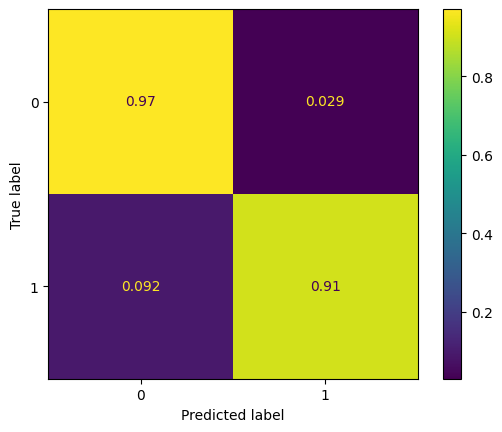

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print('accuracy_score:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))
c = confusion_matrix(y_true, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()

In [14]:
dataset = eval_dataset
n_data = len(dataset)
indices = np.array([i for i in range(n_data)])

In [15]:
print(n_data)
print(len(indices[(y_true==0)&(y_pred==1)]))
print(len(indices[(y_true==1)&(y_pred==0)]))
print(len(indices[y_true!=y_pred]))
print(len(indices[y_true==y_pred]))

1275
29
24
53
1222


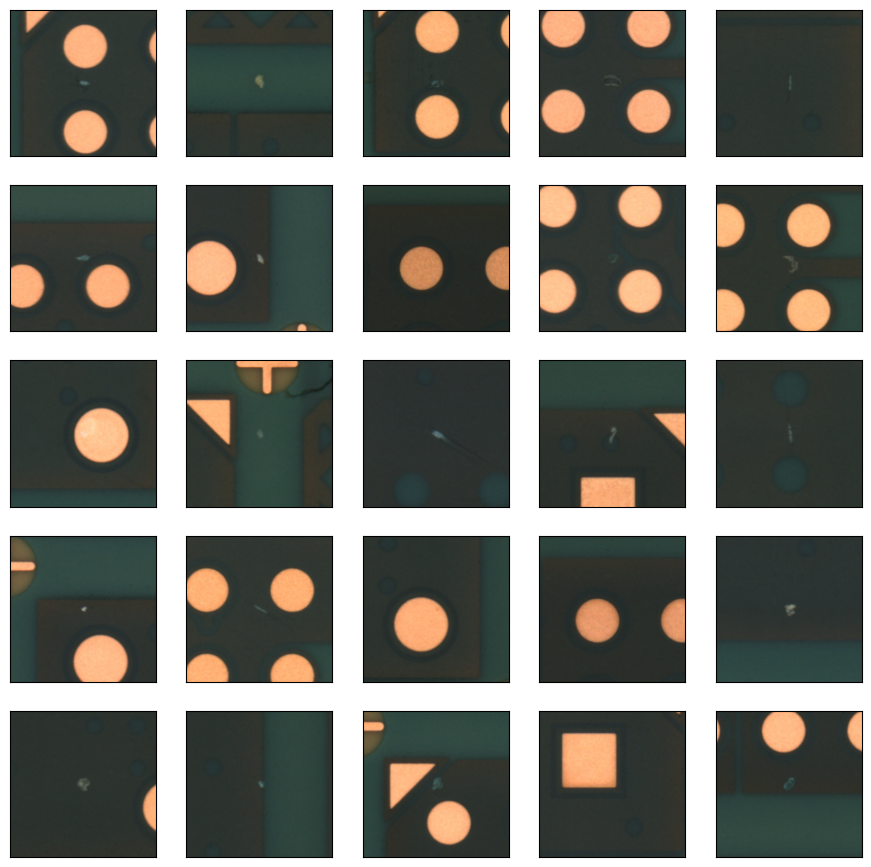

In [16]:
from matplotlib import image as mp_image
import numpy as np

plt.figure(figsize=(11,11))

indices_01 =indices[(y_true==0)&(y_pred==1)] 
perm = np.random.permutation(indices_01)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

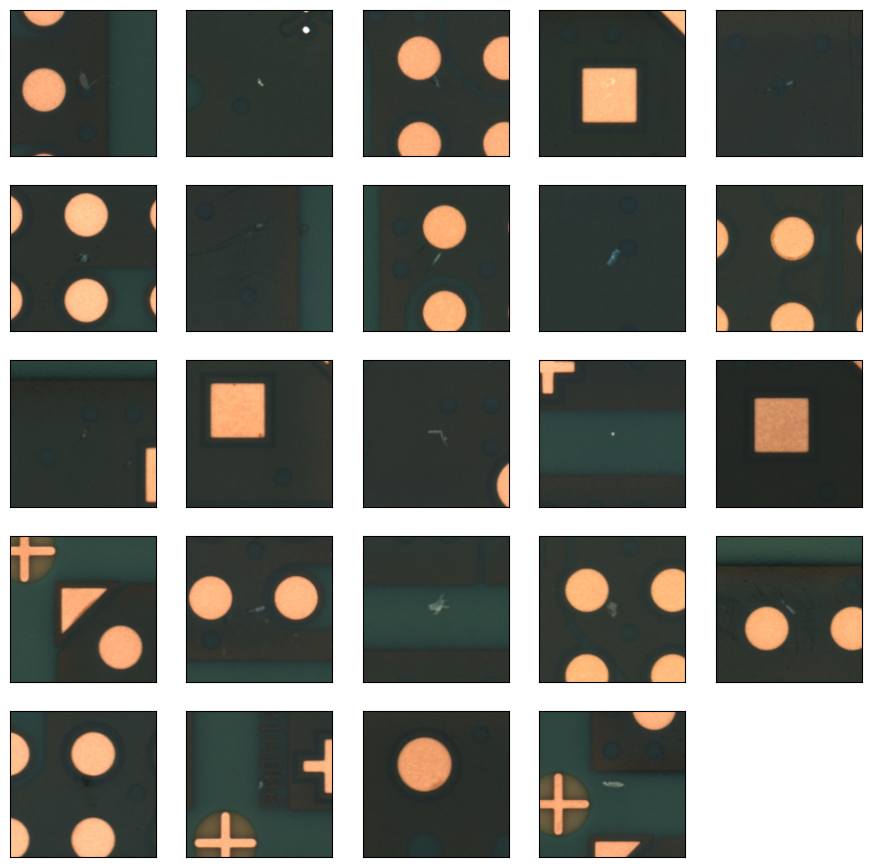

In [17]:
plt.figure(figsize=(11,11))

indices_10 =indices[(y_true==1)&(y_pred==0)] 
perm = np.random.permutation(indices_10)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

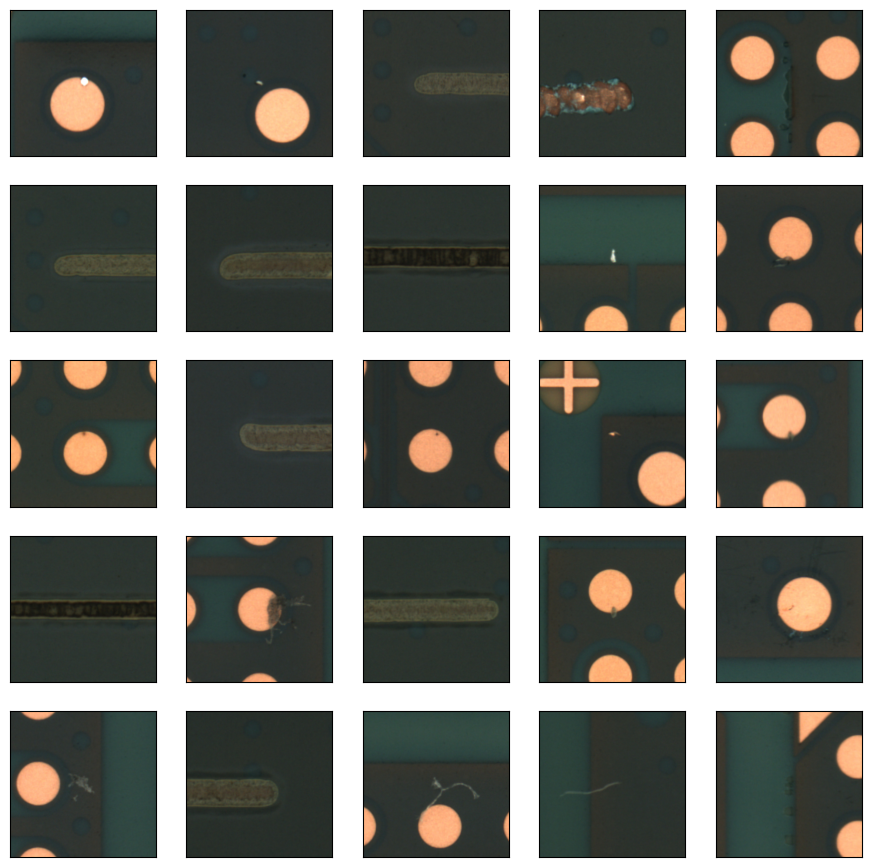

In [17]:
plt.figure(figsize=(11,11))

indices_00 =indices[(y_true==0)&(y_pred==0)] 
perm = np.random.permutation(indices_00)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

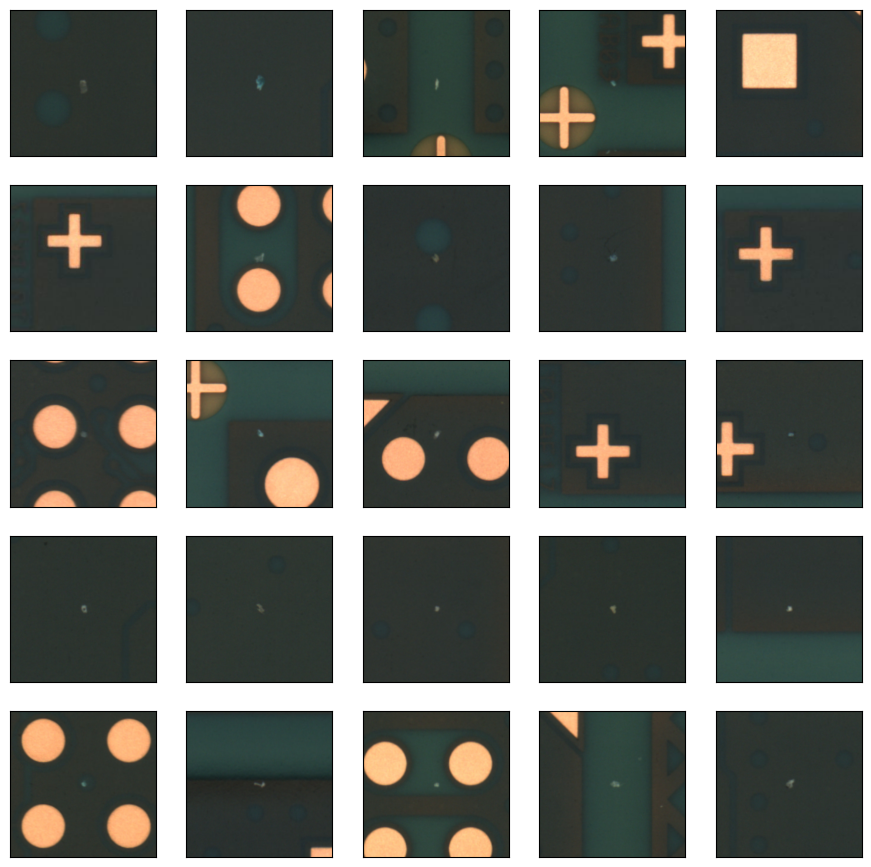

In [18]:
plt.figure(figsize=(11,11))

indices_11 =indices[(y_true==1)&(y_pred==1)] 
perm = np.random.permutation(indices_11)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

In [37]:
import glob
import numpy as np
image_files = np.array(sorted(glob.glob('PCB_data/*/*.jpg')))
image_labels = np.array([ 0 if filename.split('/')[1]=='NG' else 1 for filename in image_files])
train_ratio = 0.8
val_ratio = 0.1
n_all = len(image_labels)
n_ng = len(image_labels[image_labels==0])
n_ok = n_all - n_ng
ng_indices = np.array([i for i in range(n_ng)])
ok_indices = np.array([i for i in range(n_ng, n_all)])
np.random.seed(42)
ng_perm = np.random.permutation(ng_indices)
n_ng_train = int(n_ng*0.8)
n_ng_val = int(n_ng*0.1)
ng_train_indices = ng_perm[:n_ng_train]
ng_val_indices = ng_perm[n_ng_train:n_ng_train+n_ng_val]
ng_test_indices = ng_perm[n_ng_train+n_ng_val:]
ok_perm = np.random.permutation(ok_indices)
n_ok_train = int(n_ok*0.8)
n_ok_val = int(n_ok*0.1)
ok_train_indices = ok_perm[:n_ok_train]
ok_val_indices = ok_perm[n_ok_train:n_ok_train+n_ok_val]
ok_test_indices = ok_perm[n_ok_train+n_ok_val:]
train_indices = np.concatenate((ng_train_indices, ok_train_indices))
val_indices = np.concatenate((ng_val_indices, ok_val_indices))
test_indices = np.concatenate((ng_test_indices, ok_test_indices))


In [29]:
ok_indices

array([10154, 10155, 10156, ..., 12755, 12756, 12757])

array([0, 0, 0, ..., 0, 0, 0])